# Лабораторная работа 6. Динамическое программирование.

In [1]:
import networkx as nx
import pylab
import numpy as np
import time
import matplotlib.pyplot as plt

# Пример №1. Числа Фибоначчи

Последовательность чисел Фибоначчи задаётся рекуррентным выражением:

$$ F_n =  \begin{cases}
           0, n = 0, \\
           1, n = 1, \\
           F_{n-1}+F_{n-2}, n > 1.
          \end{cases} $$

Что даёт следующую последовательность {0, 1, 1, 2, 3, 5, 8, 13, 21, 34, …}.

Один из способов решения, который может показаться логичным и эффективным, — решение с помощью рекурсии:

In [2]:
def Fibonacci_Recursion(n):
    if n == 0:
        return 0
    if n == 1:
        return 1
    return Fibonacci_Recursion (n-1) + Fibonacci_Recursion (n-2)

Используя такую функцию, мы будем решать задачу «с конца» — будем шаг за шагом уменьшать n, пока не дойдем до известных значений.

Но эта реализация многократно повторяет решение одних и тех же задач. Это связано с тем, что одни и те же промежуточные данные вычисляются по несколько раз, а число операций нарастает с той же скоростью, с какой растут числа Фибоначчи — экспоненциально.

Один из выходов из данной ситуации — сохранение уже найденных промежуточных результатов с целью их повторного использования (кеширование). Причём кеш должен храниться во внешней области памяти.

In [3]:
def Fibonacci_Recursion_cache(n, cache):
    if n == 0:
        return 0
    if n == 1:
        return 1
    if cache[n] > 0:
        return cache[n]
    cache[n] = Fibonacci_Recursion_cache (n-1, cache) + Fibonacci_Recursion_cache (n-2, cache)
    return cache[n]

Приведенное решение достаточно эффективно (за исключением накладных расходов на вызов функций). Но можно поступить ещё проще:

In [8]:
def Fibonacci(n):
    
    fib = [0] * max(2, n + 1)
    fib[0] = 0
    fib[1] = 1
    for i in range(2, n + 1):
        fib[i] = fib[i - 1] + fib[i - 2]
        
    return fib[n]

Такое решение можно назвать решением «с начала» — мы первым делом заполняем известные значения, затем находим первое неизвестное значение, потом следующее и т.д., пока не дойдем до нужного.

Так и работает динамическое программирование: сначала решили все подзадачи (нашли все F[i] для i < n), затем, зная решения подзадач, нашли решение исходной задачи.

Проверим правильность работы этих программ:

In [9]:
N = 9
cache = [0]*(N+1)
assert Fibonacci_Recursion(N) == 34
assert Fibonacci_Recursion_cache(N, cache) == 34
assert Fibonacci(N) == 34

И их производительность:

In [12]:
n=30
a = np.zeros(n)
cache = [0]*(n+1)

In [13]:
start_time = time.time()
for i in range (n): a[i] = Fibonacci_Recursion(i)
print('%-28s %12.6e sec' % ('Fibonacci_Recursion:', time.time()-start_time))

start_time = time.time()
for i in range (n): 
    cache = [0]*(i+1)
    a[i] = Fibonacci_Recursion_cache(i,cache)
print('%-28s %12.6e sec' % ('Fibonacci_Recursion_cache:', time.time()-start_time))
    
start_time = time.time()
for i in range (n): a[i] = Fibonacci(i)
print('%-28s %12.6e sec' % ('Fibonacci:', time.time()-start_time))

Fibonacci_Recursion:         5.642195e-01 sec
Fibonacci_Recursion_cache:   9.999275e-04 sec
Fibonacci:                   0.000000e+00 sec


# Пример №2. Задача о возрастающей подпоследовательности

Пусть имеется последовательность чисел $a_1, a_2, … a_N$. Подпоследовательность $a_{i_1}, a_{i_2}, a_{i_3}$, ... называется возрастающей, если
$$ 1 < i_1 < i_2 < ... < i_k < n $$
и
$$ a_{i_1} < a_{i_2} < ... < a_{i_k} $$
Требуется найти максимальную длину возрастающей подпоследовательности. Например, для последовательности $a_i = {10, 4, 13, 7, 3, 6, 17, 33}$ одна из возрастающих подпоследовательностей есть ${4, 7, 17, 33}$.

В этой задаче длина наибольшего пути к вершине i (уравнение Беллмана) есть максимум из наибольших путей к предыдущим вершинам плюс единица:
$$ L_i = 1 + max(L_{i-1, j}, j = 1, N_{L_{i-1}}) $$.

In [14]:
def f(a, k):
    # k - номер конечного элемента
    m=0
    for i in range(k):      # для всех слева
        if (a[i] < a[k]):   # есть путь?
            p = f(a,i)      # его длина
            if (p>m): m=p   # m = max(m,p)
    return m + 1

In [17]:
a = [1, 4, 5, 2, 6, 3]
f(a, 4)

4

Чтобы повторно не решать решённые подзадачи, введём массив c размером N, хранящий значения вычисленных функций. Начальные значения его равны нулю — значению, которое не может быть верным решением любой из подзадач. Это позволит нам определить, решали ли мы эту подзадачу или нет. Если нет — запускаем решение для требуемого аргумента, и после получения результата сохраняем его.

In [18]:
def f(a, k, cache):
    # k - номер конечного элемента
    if(cache[k]!=0): return cache[k]
    m=0
    for i in range(k-1):          # для всех слева
        if (a[i] < a[k]):         # есть путь?
            p = f(a, i, cache)    # его длина
            if (p>m): m=p         # m = max(m,p)
    cache[k] = m+1
    return cache[k]

In [19]:
c = [0]*5
a = [1, 4, 2, 5, 3]
f(a, 4, c)

3

# Пример №3. Задача о банкомате

Если в задаче о рюкзаке сделать варианты предметов неисчерпаемыми можно перейти к задаче о банкомате. 
Постановка: В банкомате имеется неограниченное количество банкнот (b1, b2, . . . , bn) заданных номиналов. Нужно выдать требуемую сумму денег наименьшим количеством банкнот.
Как мы уже выяснили, жадное решение возможно не для всех наборов входных данных. Например, при b = {1, 6, 10} и x = 12 жадное решение даст ответ 3 (10 + 1 + 1), хотя существует более оптимальное решение 2 (6 + 6). 
Сделаем задачу о банкомате похожей на задачу о количестве маршрутов.

Для каждой суммы проведём стрелку к узлу с новой разрешённой суммой. Уравнение Беллмана:

$$ f(x) =  \begin{cases}
            min(f(x-b_i))+1, x > 0 \\
            \quad 0 \quad, x = 0 \\
            \quad \infty \quad, x < 0
           \end{cases} $$

In [30]:
googol = 999999999

def f(x,b,cache):
    n = len(b)
    if (x<0): return googol
    elif(x==0): return 0
    elif(cache[x]>0): return cache[x]
    minim = googol
    for i in range(n):
        r = f(x-b[i],b, cache)
        if (r<minim): minim=r
    cache[x] = minim + 1
    return cache[x]

In [44]:
cache = [0]*10
b = [1, 4, 6]
f(9,b,cache)

3

Доведя решение задачи до ответа и имея кэш-таблицу, можно восстановить решение без дополнительной информации.
Предположим, что мы знаем, что точный ответ при заданных начальных значениях есть 7. Тогда возникает вопрос: какой предыдущий ход мы сделали, чтобы попасть в заключительную позицию? Введём термин ранг для обозначения наименьшего числа ходов, требуемого для достижения текущей позиции из начальной. Тогда каждый ход решения всегда переходит в позицию с рангом, большим строго на единицу, и это позволяет нам придумать следующий алгоритм:

1. решение основной задачи дало в ответе k, это — ранг заключительной позиции,
2. делаем позицию текущей,
3. если текущая позиция имеет ранг 0, то это — начальная позиция и алгоритм завершён,
4. рассматриваем позиции, ведущие в текущую, и выбираем из них произвольную с рангом k − 1,
5. запоминаем ход, который привёл из позиции ранга k − 1 в ранг k,
6. понижаем ранг – k → k − 1 и переходим к 2.

In [24]:
def buildSolution(x, b, cache):
    n = len(b)
    ret = []
    for k in range (cache[x],-1,-1):
        for i in range(n):
            r = x - b[i]
            if (r >= 0 and cache[r] == k-1):
                x = r
                ret.append(b[i])
                break
    return ret

In [25]:
buildSolution(9, b, cache)

[1, 4, 4]

# Пример №4. Задача о кузнечике.

Рассмотрим следующую задачу. На числовой прямой сидит кузнечик, который может прыгать вправо на одну или на две единицы. Первоначально кузнечик находится в точке с координатой 1. Определите количество различных маршрутов кузнечика, приводящих его в точку с координатой n.

Обозначим количество маршрутов кузнечика, ведущих в точку с координатой n, как K[n]. Прежде всего заметим, что существует ровно один маршрут из точки 1 в точку 1 — он не содержит ни одного прыжка. В точку 2 можно прыгнуть единственным способом — из точки 1.

Как вычислить K[n]? В точку n кузнечик может попасть двумя способами — из точки n-2 при помощи прыжка длиной 2 и из точки n-1 прыжком длины 1. То есть число способов попасть в точку n равно сумме числа способов попасть в точку (n-1) и (n-2), что позволяет выписать рекуррентное соотношение: 

$$K[n] = K[n-1] + K[n-2]$$.

Можно заметить, что данная задача по сути свелась к числам Фибоначчи, поэтому мы не будем выписывать её решение.

# Упражнение №1

Решите задачу о количестве способов достичь точки n из точки 1, если кузнечик умеет прыгать +1, +2 и +3.

# Упражнение №2 Задача о кузнечике со стоимостями посещения точек

Пусть кузнечик прыгает на одну или две точки вперед, а за прыжок в каждую точку необходимо заплатить определенную стоимость, различную для различных точек. Стоимость прыжка в точку i задается значением price[i] списка price. Необходимо найти минимальную стоимость маршрута кузнечика из точки 0 в точку n.

На этот раз нам необходимо модифицировать определение целевой функции. Пусть C[n] — минимальная стоимость пути из 1 в n.

Выведем рекуррентное соотношение для этой функции.Чтобы попасть в точку n мы должны попасть в неё последним прыжком из (n-1) или (n-2). Минимальные стоимости этих маршрутов будут равны С[n-1] и С[n-2] соответственно, к ним придется добавить значение price[n] за прыжок в клетку n. Но из двух клеток мы можем выбрать любую.

Нужно выбрать тот маршрут, который имеет наименьшую стоимость. Ур. Беллмана: 

$$C[n] = min(C[n-1], C[n-2]) + price[n]$$.

Вычислить значение целевой функции также лучше при помощи динамического программирования, а не рекурсии.

Напишите функцию вычисления наименьшей стоимость достижения клетки n из клетки 1

# Упражнение №3 Восстановление наиболее выгодной траектории
Итак, мы нашли список С, где будет записана минимальная стоимость маршрута для всех точек от 1 до n.

Но помимо нахождения наименьшей стоимости маршрута, разумеется, хотелось бы найти и сам маршрут минимальной стоимости. Такая задача называется задачей «восстановления ответа».

Для восстановления ответа будем для каждой точки запоминать номер точки prev[i], из которой кузнечик попал в точку i, если он будет передвигаться по пути минимальной стоимости. То есть prev[i] — это точка, предшествующая точке с номером i на пути минимальной стоимости (также говорят, что Prev — это массив предшественников). Как определить prev[i]? Если C[i-1] < C[i-2], то кузнечик попал в точку i из точки (i-1), поэтому prev[i] = i - 1, иначе prev[i] = i - 2.

Для восстановления пути необходимо начать с точки n и переходить от каждой точки к ее предшественнику, пока путь не дойдет до начальной точки с номером 0. Номера всех вершин будем добавлять в список path. В конце в список path добавляется начальная вершина номер 1, которая не была обработана в основном цикле, а затем весь список path разворачивается в обратном порядке (т. к. вершины добавляются в обратном порядке, от конечной к начальной).

Модифицируйте алгоритм вычисления значений целевой функции так, чтобы вычислить значения prev[i], и восстановите траекторию наименьшей стоимости из точки 1 в точку n.

1

# Пример №5. Расстояние редактирования

Часто текстовый редактор, подозревая опечатку, предлагает заменить написанное слово на близкое. Что значит «близкое»? 

Количество операций для превращения одного слова в другое называется расстоянием редактирования или расстоянием Левенштейна (ИПМ им. Келдыша). Это расстояние — мера различия между двумя строками. Этой мерой измеряют сходство или различие двух генных последовательностей и т.д.
Задача. Определить минимальное количество операций для преобразования одного слова в другое, при следующих допустимых операциях:
- замена одной буквы на другую;
- вставка одной буквы;
- удаление одной буквы.

Например, сколько нужно операций, чтобы превратить слово СЛОН в слово ОГОНЬ? Например, это можно сделать следующей последовательностью:
СЛОН → СГОН → СГОНЬ → ОГОНЬ.
Последовательность переходов, которую мы описали, не обладает нужными свойствами (последовательным увеличением сложности задачи).А есть ли нужная нам последовательность, в которой каждая подзадача решается на подстроке всё более возрастающей длины? Конечно:
1. В префиксах строк длины 1 С и О меняем букву С на О. СЛОН → ОЛОН.
2. В префиксах длины 2 меняем Л на Г. ОЛОН → ОГОН.
3. В префиксах длины 4 добавляем букву Ь. ОГОН → ОГОНЬ.

И так, необходимо найти расстояние редактирования между $x[1...m]$ и $y[1...n]$. Будем искать расстояние редактирования между префиксами первой строки, $x[1...i]$, и префиксами второй, $y[1...j]$, обозначив эти расстояния $E[i,j]$. Конечная цель – вычисление $E[m, n]$.

Например, $E[7,5]$:
$$ \fbox{E X P O N E N} T I A L $$
$$ \fbox{P O L Y N} O M I A L $$

Значения $E[i,j]$ удобно представлять в виде таблицы. Для удобства добавим один лишний левый столбеци одну лишнюю верхнюю строку к этой таблице. Заполним их последовательно возрастающими числами. Эти числа означают, что пустая строка может превратиться в образец за число операций, равное длине образца. 

Очевидно, что при такой записи в каждуюследующую клетку можно попасть только из левой, верхне или по диагонали из левой верхне. При этом из этих вариантов выбирается минимальный и к нему прибавляются затраты на новое редактирование: 0 - если на пересечении текущего столбца и строки стоят одинаковые буквы и 1 - если разные. Т.е. ур. Беллмана:

$$ E[i,j] = min(1 + E[i-1, j], 1 + E[i, j-1], d(i, j) + E[i-1, j-1]), $$
$$ d(i, j) = \begin{cases}
                 0, x[i] = y[j] \\
                 1, x[i] \neq y[j]
                 \end{cases} $$

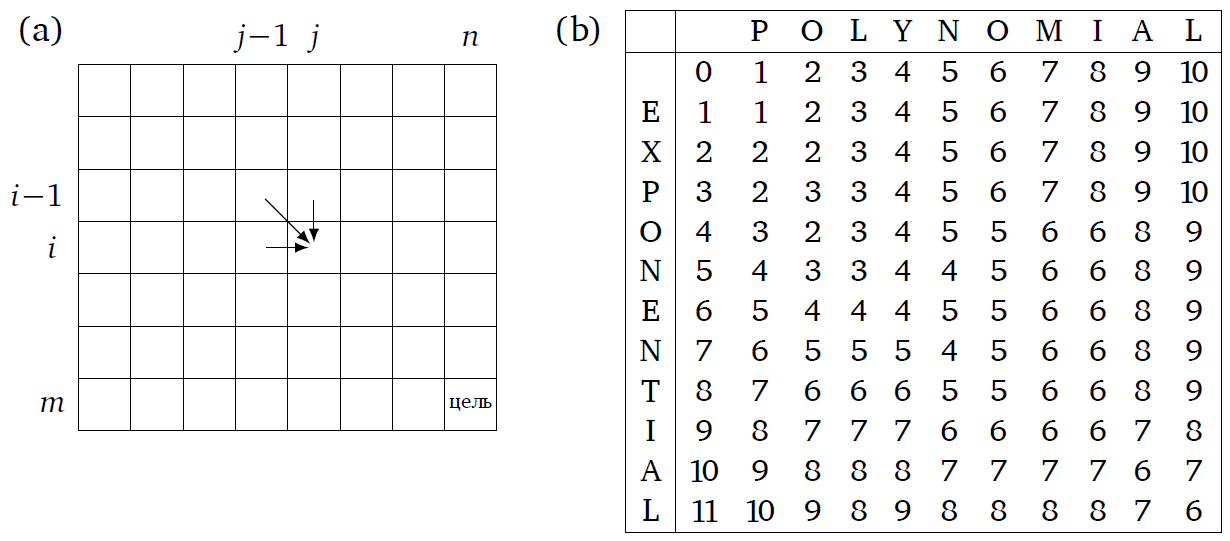

In [51]:
# Так можно добавлять картинки

from IPython.display import Image             # вызов из библиотеки определённой функции
Image("Расстояние редактирования.png")        # вызов функции и передача ей в качестве аргумента пути к файлу 

# (в данном случае фаил находится в той же папке)

# Упражнение №4.

Напишите программу вычисляющую расстояние редактирования.

# Домашнее задание (базовое):

# Задание №1. Гиперкузнечик.

Решите задачу о количестве способов достичь точки n из точки 1, если кузнечик умеет прыгать +1, +2 и *3.

# Задание №2. Наибольшая общая подпоследовательность.

Рассмотрим две строки (или числовые последовательности) A и B. Пусть первая строка состоит из n символов $a_0, ... a_n$, вторая строка состоит из m символов $b_0, ..., b_m$. Подпоследовательностью данной строки (последовательности) называется некоторое подмножество символов исходной строки, следующих в том же порядке, в котором они идут в исходной строке, но не обязательно подряд. Если в строке n символов, то у нее $2^n$ различных подпоследовательностей: каждый из n символов строки может либо входить, либо не входить в любую выбранную подпоследовательность. Пустая подпоследовательность не содержит ни одного элемента и также является подпоследовательностью любой строки.

Рассмотрим задачу для двух данных строк найти такую строку наибольшей длины, которая была бы подпоследовательностью каждой из них. Например, если A='abcabaac', B='baccbca' то у строк A и B них есть общая подпоследовательность длины 4, например, 'acba' или 'acbc'.

Данную задачу можно решить перебором  например, перебрав все $2^n$ подпоследовательностей первой строки и для каждой их них проверив, является ли она подпоследовательностью второй строки. Но при помощи динамического программирования эту же задачу можно решить за сложность O(nm).

Напишите программу решающую данную задачу с помощью алгоритма, полученного на основе динамического программирования. 

# Задание №3. 

Даны две последовательности целых чисел $a_0, ... a_n$ и $b_0, ..., b_m$. Выяснить, является ли вторая последовательность подпоследовательностью первой, то есть можно ли из первой вычеркнуть некоторые члены так, чтобы осталась вторая.

# Задание №4. Мячик на лесенке.

На вершине лесенки, содержащей N ступенек, находится мячик, который начинает прыгать по ним вниз, к основанию. Сначала мячик может прыгнуть максимум на N/2, но с каждым ударом о ступеньку эта величина сокращается вдвое пока он не начинает катиться, перекатываясь с одной ступеньке на другую. Так мячик может прокатиться ещё N/16 ступенек. 

Определите число всевозможных "маршрутов" мячика и найдите максимально возможную длину лестницы N.

# Домашнее задание (дополнительное):

In [49]:
# Так можно добавлять картинки

from IPython.display import Image # вызов из библиотеки определённой функции
Image("официант.png")             # вызов функции и передача ей в качестве аргумента пути к файлу 

# (в данном случае фаил находится в той же папке)

# Задача о рюкзаке.

Решите задачу о рюкзаке методом динамического программирования.

Естественно важно правильно выбрать подзадачи. В данном случае есть два естественных способа: рассмотреть рюкзак меньшей ёмкости или же меньшее число предметов. 

Для того чтобы понять, какой подход действительно работает, обычно приходится немного поэкспериментировать.

# Задача коммивояжёра.

Коммивояжёр должен посетить по разу каждый город из большого списка и вернуться в свой родной город. Он знает расстояния между всеми парами городов. В каком порядке лучше всего посещать города, чтобы минимизировать пройденное расстояние?

Если перебирать все маршруты (их $(n-1)!$), потребуется время $O(n!)$ (вычисление длины маршрута производится за время $O(n)$). Однако, динамическое программирование позволяет решить эту задачу быстрее, хоть и не слишком.

При испотльзовании динамического программирования поскольку мы ищем маршрут, естественной подзадачей является нахождение начальной части маршрута. Предположим, мы вышли из города 1, посетили несколько городов и сейчас находимся в городе j. Существенной информацией об этом частичном маршруте является где мы находимся (j), а также где мы уже побывали (чтобы не идти туда второй раз). Это и приводит нас к необходимой подзадаче.

Всего есть не более $2^nn$ подзадач, и решение для каждой из них находится за линейное время. Поэтому общее время работы есть $O(n^22^n)$.